# Sberbank Housing - Baseline Model

Data source: https://www.kaggle.com/competitions/sberbank-russian-housing-market/data

## Imports

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# Load data
house_data = pd.read_csv(r"data/sberbank_housing.csv", index_col=0, low_memory=False)

house_data.head()

,id,timestamp,price_doc,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,product_type,ecology,sub_area,raion_popul,kindergarten_km,school_km,park_km,railroad_km,metro_min_walk
0,1,2011-08-20,5850000,43,27.0,NaN,4.0,NaN,NaN,NaN,NaN,Investment,good,Bibirevo,155572,0.145700,0.177975,2.158587,1.305159,13.575119
1,2,2011-08-23,6000000,34,19.0,NaN,3.0,NaN,NaN,NaN,NaN,Investment,excellent,Nagatinskij Zaton,115352,0.147754,0.273345,0.550690,0.694536,7.620630
2,3,2011-08-27,5700000,43,29.0,NaN,2.0,NaN,NaN,NaN,NaN,Investment,poor,Tekstil'shhiki,101708,0.049102,0.158072,0.374848,0.700691,17.351515
3,4,2011-09-01,13100000,89,50.0,NaN,9.0,NaN,NaN,NaN,NaN,Investment,good,Mitino,178473,0.179441,0.236455,0.078090,1.999265,11.565624
4,5,2011-09-05,16331452,77,77.0,NaN,4.0,NaN,NaN,NaN,NaN,Investment,excellent,Basmannoe,108171,0.247901,0.376838,0.258289,0.084113,8.266305


In [35]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27000 entries, 0 to 26999
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               27000 non-null  int64  
 1   timestamp        27000 non-null  object 
 2   price_doc        27000 non-null  int64  
 3   full_sq          27000 non-null  int64  
 4   life_sq          21463 non-null  float64
 5   kitch_sq         17428 non-null  float64
 6   floor            26833 non-null  float64
 7   max_floor        17428 non-null  float64
 8   build_year       14131 non-null  float64
 9   num_room         17428 non-null  float64
 10  state            13933 non-null  float64
 11  product_type     27000 non-null  object 
 12  ecology          27000 non-null  object 
 13  sub_area         27000 non-null  object 
 14  raion_popul      27000 non-null  int64  
 15  kindergarten_km  27000 non-null  float64
 16  school_km        27000 non-null  float64
 17  park_km          

## Load Data & Initial Exploration

In [36]:
# Clean column names
house_data.columns = [c.lower().strip().replace(" ", "_") for c in house_data.columns]

# Drop non-predictive columns
house_data = house_data.drop(columns=["timestamp", "id"])

## Categorical Features Overview

Examine categorical columns to determine encoding strategy based on cardinality.

In [37]:
# Identify categorical columns
categorical_cols = house_data.select_dtypes(include=['object']).columns.tolist()

print(f"\nCategorical columns: {len(categorical_cols)}")
print("="*60)

# Initialize lists for cardinality-based categorization
low_card = []
high_card = []
cardinality_threshold = 10

for col in categorical_cols:
    n_unique = house_data[col].nunique()
    n_missing = house_data[col].isna().sum()
    missing_pct = (n_missing / len(house_data)) * 100
    
    # Categorize based on cardinality
    if n_unique < cardinality_threshold:
        low_card.append(col)
        cardinality_label = "LOW"
    else:
        high_card.append(col)
        cardinality_label = "HIGH"
    
    print(f"\n{col}: [{cardinality_label} cardinality]")
    print(f"  Unique values: {n_unique}")
    print(f"  Missing: {n_missing} ({missing_pct:.1f}%)")
    print(f"  Top 5 values:")
    print(house_data[col].value_counts().head(5).to_string().replace('\n', '\n    '))

print("\n" + "="*60)
print("\nEncoding Strategy:")
print(f"  LOW cardinality (<{cardinality_threshold} unique)  → One-Hot Encoding: {low_card}")
print(f"  HIGH cardinality (≥{cardinality_threshold} unique) → Frequency Encoding: {high_card}")
print("="*60)


Categorical columns: 3

product_type: [LOW cardinality]
  Unique values: 2
  Missing: 0 (0.0%)
  Top 5 values:
product_type
    Investment       17542
    OwnerOccupier     9458

ecology: [LOW cardinality]
  Unique values: 5
  Missing: 0 (0.0%)
  Top 5 values:
ecology
    poor            7215
    no data         6570
    good            6548
    excellent       3419
    satisfactory    3248

sub_area: [HIGH cardinality]
  Unique values: 146
  Missing: 0 (0.0%)
  Top 5 values:
sub_area
    Nekrasovka                 1540
    Poselenie Sosenskoe        1522
    Poselenie Vnukovskoe       1048
    Poselenie Moskovskij        807
    Poselenie Voskresenskoe     693


Encoding Strategy:
  LOW cardinality (<10 unique)  → One-Hot Encoding: ['product_type', 'ecology']
  HIGH cardinality (≥10 unique) → Frequency Encoding: ['sub_area']


## Target Distribution Analysis

**Why check target distribution?**

1. **Normality Assumption**: Linear regression assumes residuals follow a bell-shaped curve distribution
2. **Homoscedasticity**: Residuals should be scattered randomly with no patterns

Target distribution is one of the biggest factors affecting both assumptions.

**Goal**: Homoscedastic + Normal residuals (IDEAL)

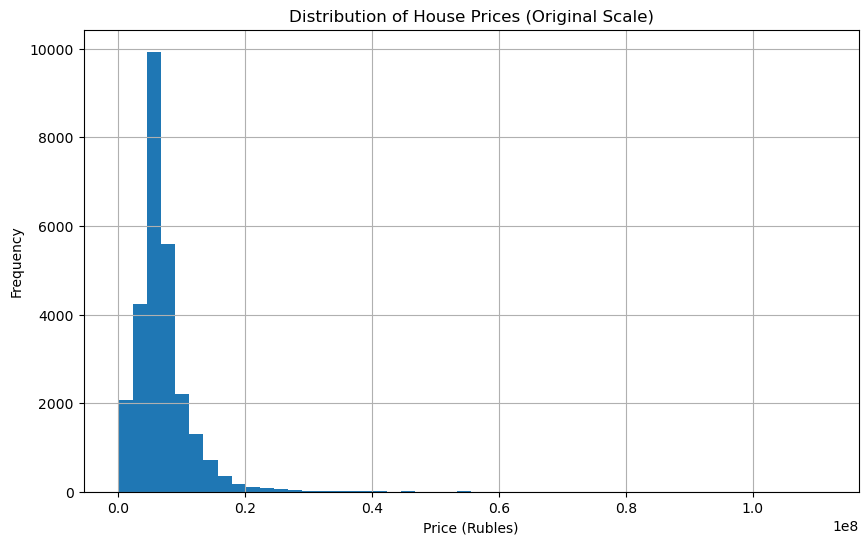

In [38]:
# Visualize the distribution of our target variable (house prices)
house_data["price_doc"].hist(bins=50, figsize=(10, 6))
plt.title("Distribution of House Prices (Original Scale)")
plt.xlabel("Price (Rubles)")
plt.ylabel("Frequency")
plt.show()

In [39]:
# Let's apply log transfrom to the target variable to reduce skewness
house_data["price_doc"] = np.log1p(house_data["price_doc"])

## Train-Test Split

Split strategy: 80% training, 20% testing

In [40]:
X = house_data.drop("price_doc", axis=1)
y = house_data["price_doc"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (21600, 17)
Test set: (5400, 17)


## Apply Categorical Encoding

In [42]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode low cardinality columns (using lists from earlier)

#ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore', handle_missing='use_encoded_value')
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
ohe.fit(X_train[low_card])

# Transform both
X_train_ohe = ohe.transform(X_train[low_card])
X_test_ohe = ohe.transform(X_test[low_card])

# Convert to DataFrames with proper column names
ohe_cols = ohe.get_feature_names_out(low_card)
X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=ohe_cols, index=X_train.index)
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=ohe_cols, index=X_test.index)
X_train[ohe_cols] = X_train_ohe_df
X_test[ohe_cols] = X_test_ohe_df

# Drop originals
X_train.drop(columns=low_card, inplace=True)
X_test.drop(columns=low_card, inplace=True)

print(f"One-hot encoded {len([c for c in low_card if c in X.columns])} low-cardinality features: {[c for c in low_card if c in X.columns]}")
print(f"New one-hot features names: {ohe_cols}")

# Frequency encode high cardinality columns
high_card_in_data = [c for c in high_card if c in X_train.columns]
if high_card_in_data:
    for col in high_card_in_data:
        # Calculate frequency encoding from training set
        freq_map = X_train[col].value_counts(normalize=True).to_dict()
        
        # Apply to both train and test
        X_train[f'{col}_freq'] = X_train[col].map(freq_map).fillna(0)
        X_test[f'{col}_freq'] = X_test[col].map(freq_map).fillna(0)
        
        # Drop original categorical column
        X_train = X_train.drop(columns=[col])
        X_test = X_test.drop(columns=[col])
    
    print(f"Frequency encoded {len(high_card_in_data)} high-cardinality features: {high_card_in_data}")

print(f"\nFinal shape after encoding:")
print(f"  Training set: {X_train.shape}")
print(f"  Test set: {X_test.shape}")

One-hot encoded 2 low-cardinality features: ['product_type', 'ecology']
New one-hot features names: ['product_type_OwnerOccupier' 'ecology_good' 'ecology_no data'
 'ecology_poor' 'ecology_satisfactory']
Frequency encoded 1 high-cardinality features: ['sub_area']

Final shape after encoding:
  Training set: (21600, 20)
  Test set: (5400, 20)


## Baseline Model with Categorical Encoding

Uses complete numeric columns plus one-hot encoded low cardinality categorical features.

In [43]:
# Use all numeric columns (including encoded categoricals) with simple median imputation
from sklearn.impute import SimpleImputer

# Get all numeric columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Simple median imputation for missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train[numeric_cols])
X_test_imputed = imputer.transform(X_test[numeric_cols])

# Train baseline model
baseline_model = Ridge(random_state=42)
baseline_model.fit(X_train_imputed, y_train)

# Predictions
baseline_pred = baseline_model.predict(X_test_imputed)

print(f"Features used: {len(numeric_cols)} (numeric + encoded categorical)")

Features used: 20 (numeric + encoded categorical)


In [44]:
# Calculate metrics on log scale
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

# Convert back to dollar scale for interpretation
baseline_pred_dollars = np.expm1(baseline_pred)
y_test_dollars = np.expm1(y_test)
baseline_rmse_dollars = np.sqrt(mean_squared_error(y_test_dollars, baseline_pred_dollars))

residuals = y_test - baseline_pred

In [45]:
print(f"   RMSE: {baseline_rmse:.3f} (log scale)")

baseline_rmse_dollars = np.sqrt(mean_squared_error(y_test_dollars, baseline_pred_dollars))
print(f"   RMSE: {baseline_rmse_dollars:.3f} (rubles scale)")

   RMSE: 0.525 (log scale)
   RMSE: 5626709.440 (rubles scale)


In [15]:
# # Calculate residuals
# residuals = y_test - baseline_pred

# # 1. Check homoscedasticity
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.scatter(baseline_pred, residuals, alpha=0.6)
# plt.xlabel("Fitted Values (Predictions)")
# plt.ylabel("Residuals")
# plt.title("Residuals vs Fitted")
# plt.axhline(y=0, color='red', linestyle='--')

# # 2. Check normality of residuals
# plt.subplot(1, 2, 2)
# from scipy import stats
# stats.probplot(residuals, dist="norm", plot=plt)
# plt.title("Q-Q Plot - Residual Normality")

# plt.tight_layout()
# plt.show()

## Save Baseline for Comparison

In [46]:
# save our baseline model's rmse to compare later
baseline_rmse_dollars = str(np.sqrt(mean_squared_error(y_test_dollars, baseline_pred_dollars)))
with open("baseline_rmse.txt","w") as f:
    f.write(baseline_rmse_dollars)
    f.flush()